In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error,mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=22,8


tf.random.set_seed(42)


In [2]:
data=pd.read_excel("DatabyDay-it-all-8years.xlsx")
data.index=data['Date']
data.drop(columns='Date',inplace=True)
data=data.resample('W').sum()
data.head(400)
data=data.iloc[1:,:]
data.index=pd.to_datetime(data.index)

In [3]:
data['week']=data.index.week
data['month']=data.index.month
data['quarter']=data.index.quarter

<ipython-input-3-3af9b3e3f6f9>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week']=data.index.week


In [4]:
data.head()

,Truck,week,month,quarter
Date,,,,
2011-01-09,25.0,1,1,1
2011-01-16,19.0,2,1,1
2011-01-23,23.0,3,1,1
2011-01-30,25.0,4,1,1
2011-02-06,12.0,5,2,1


<AxesSubplot:xlabel='Date', ylabel='Truck'>

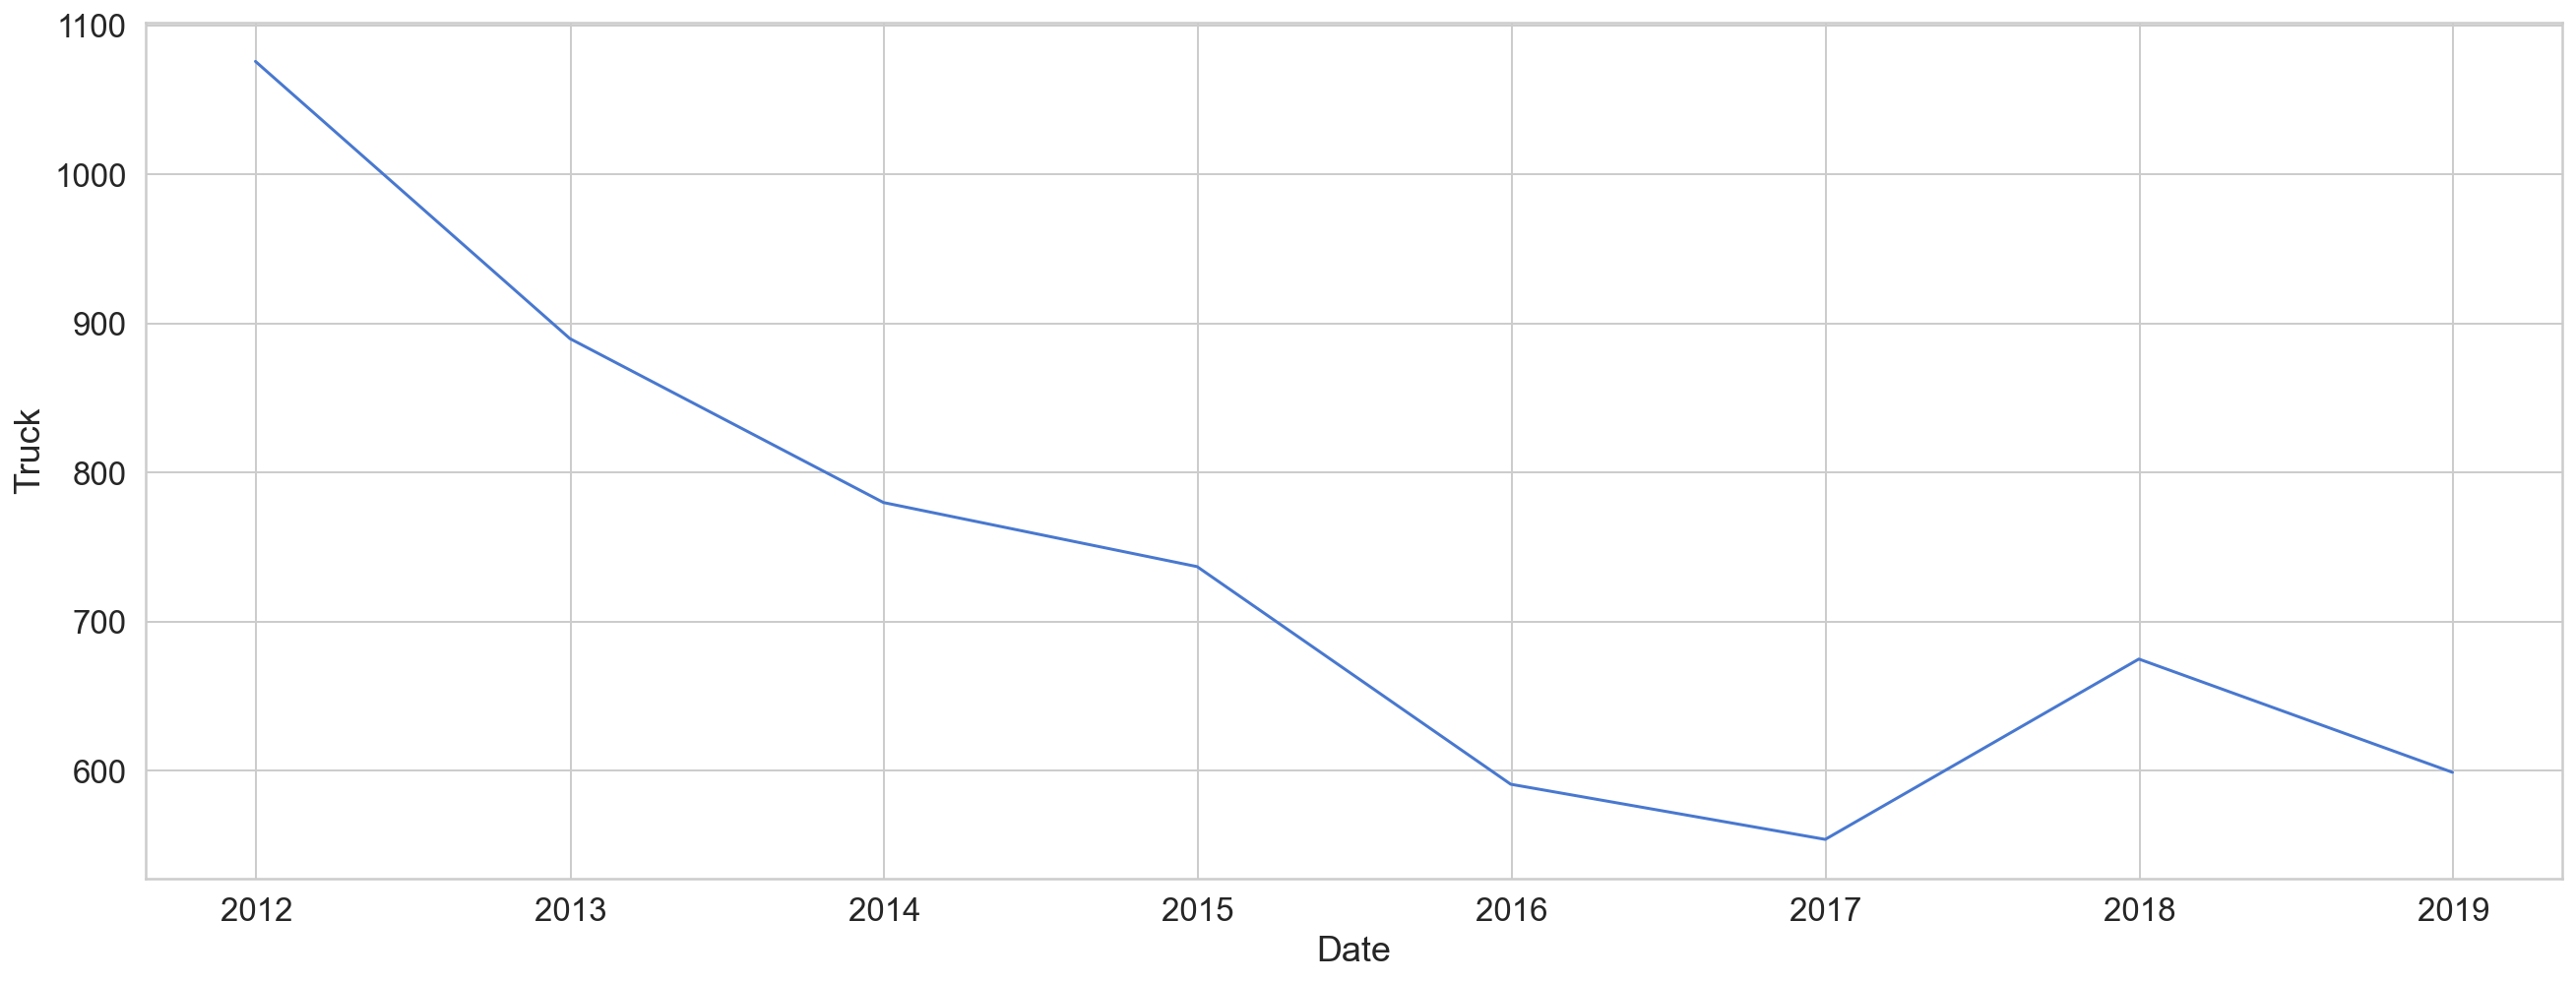

In [5]:
data_by_year=data.resample('Y').sum()
sns.lineplot(x=data_by_year.index,y='Truck',data=data_by_year)

<AxesSubplot:xlabel='Date', ylabel='Truck'>

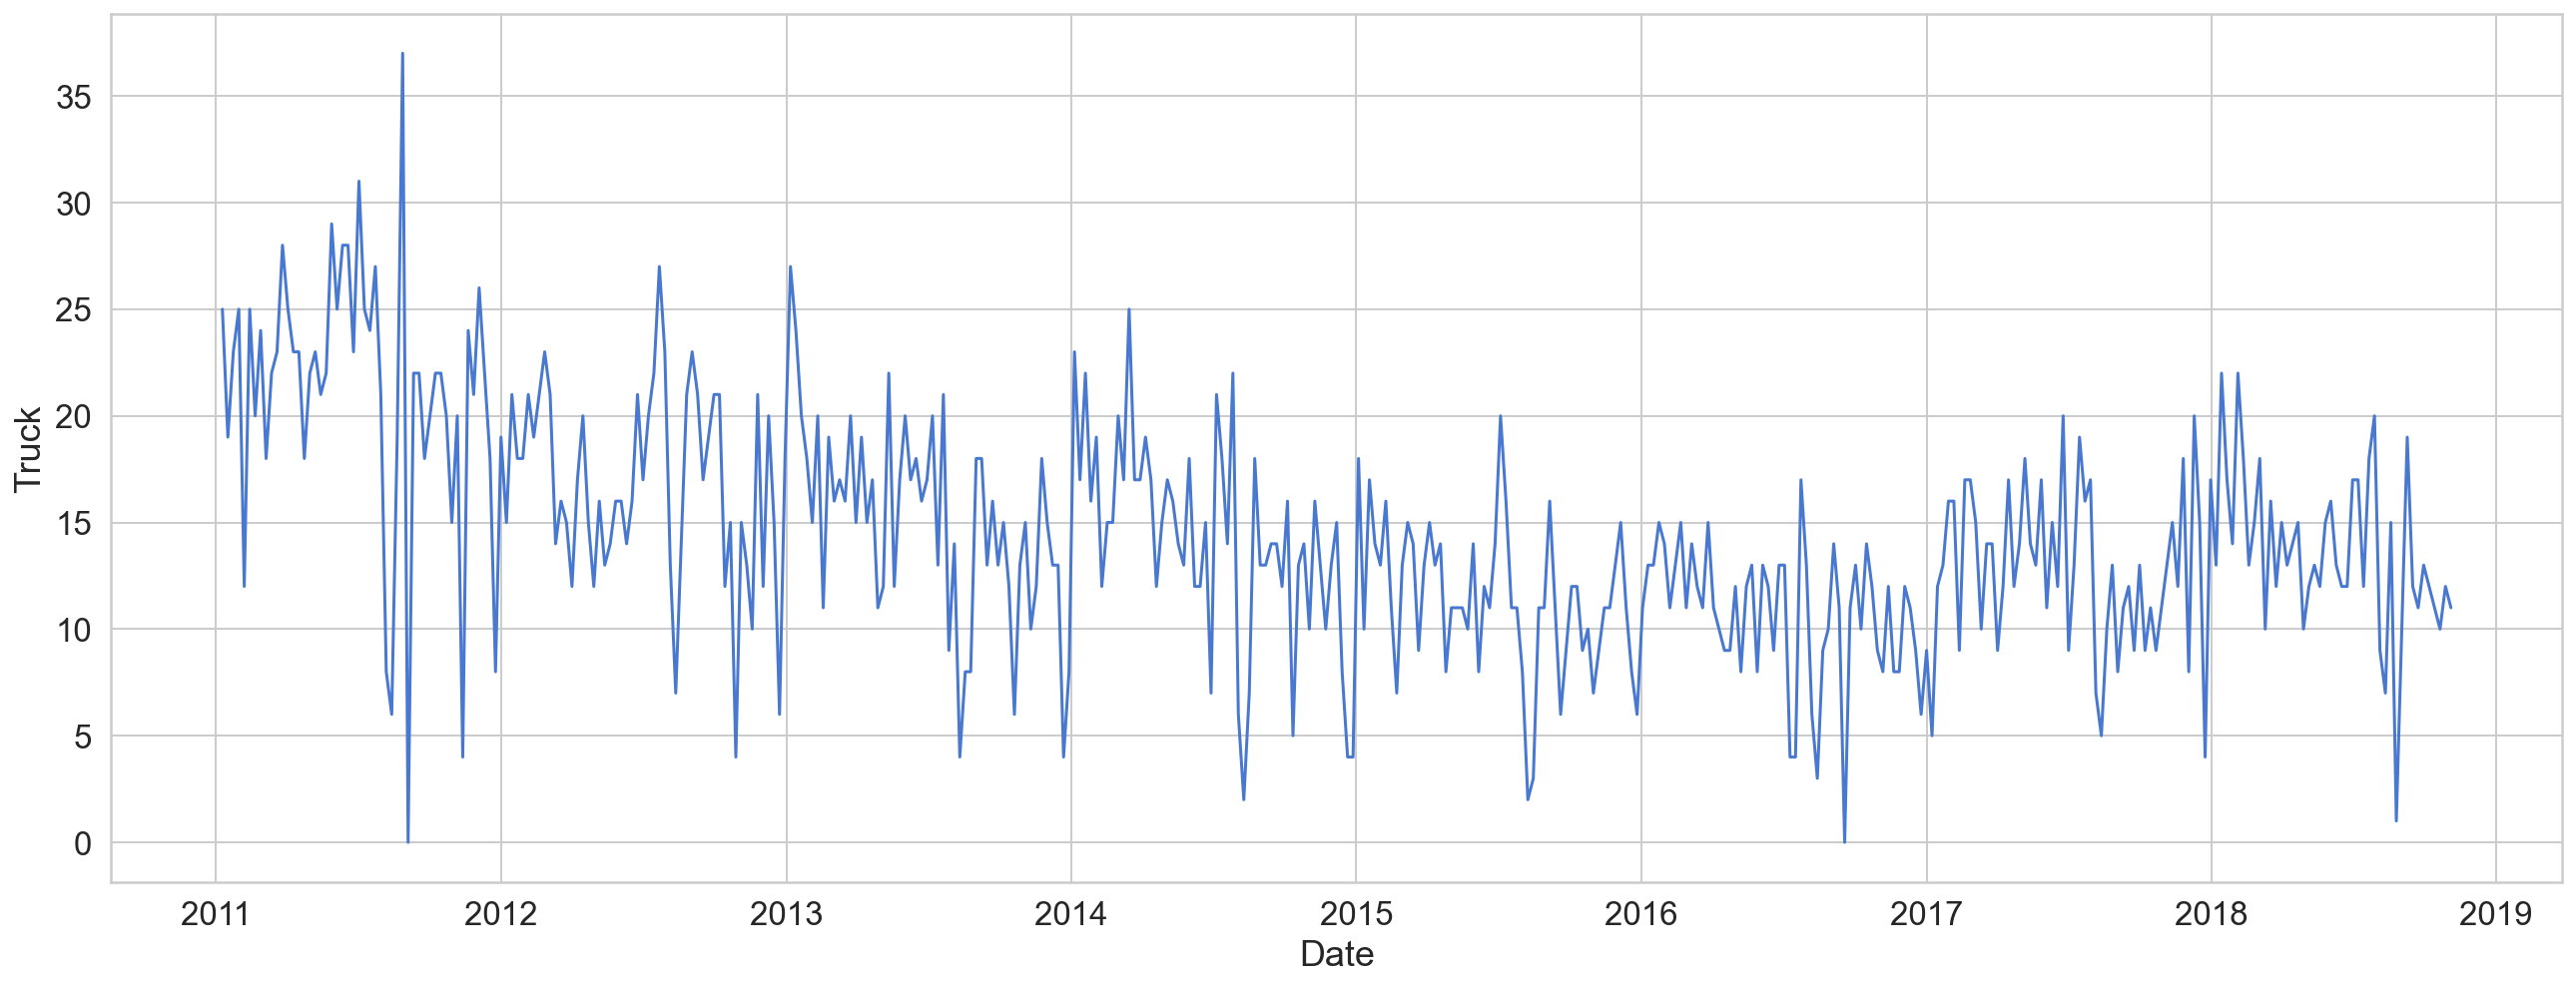

In [6]:
sns.lineplot(x=data.index,y='Truck',data=data)

<AxesSubplot:xlabel='month', ylabel='Truck'>

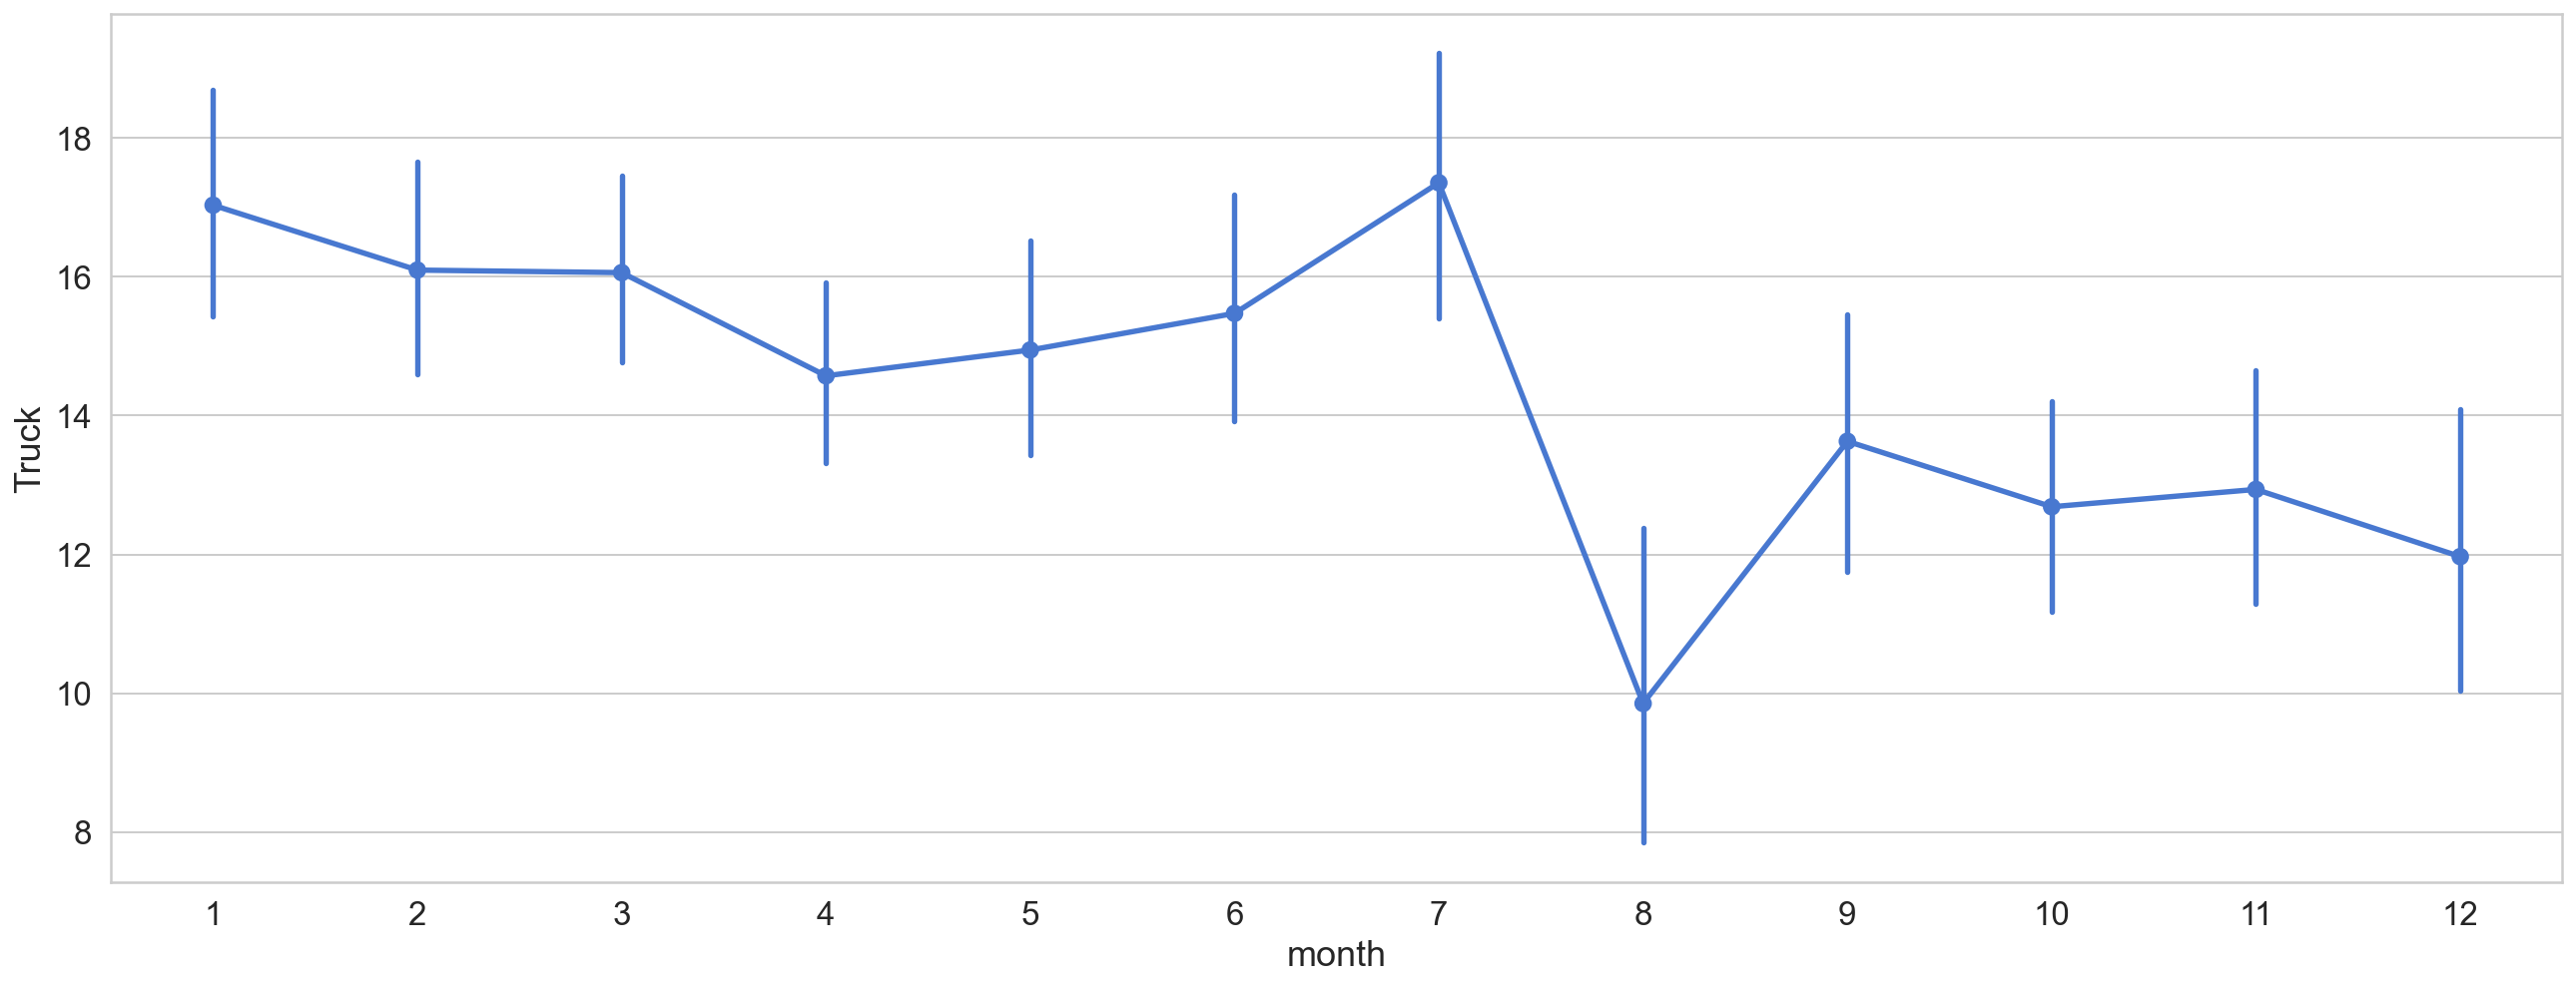

In [7]:
sns.pointplot(data=data,x='month',y='Truck')

<AxesSubplot:xlabel='week', ylabel='Truck'>

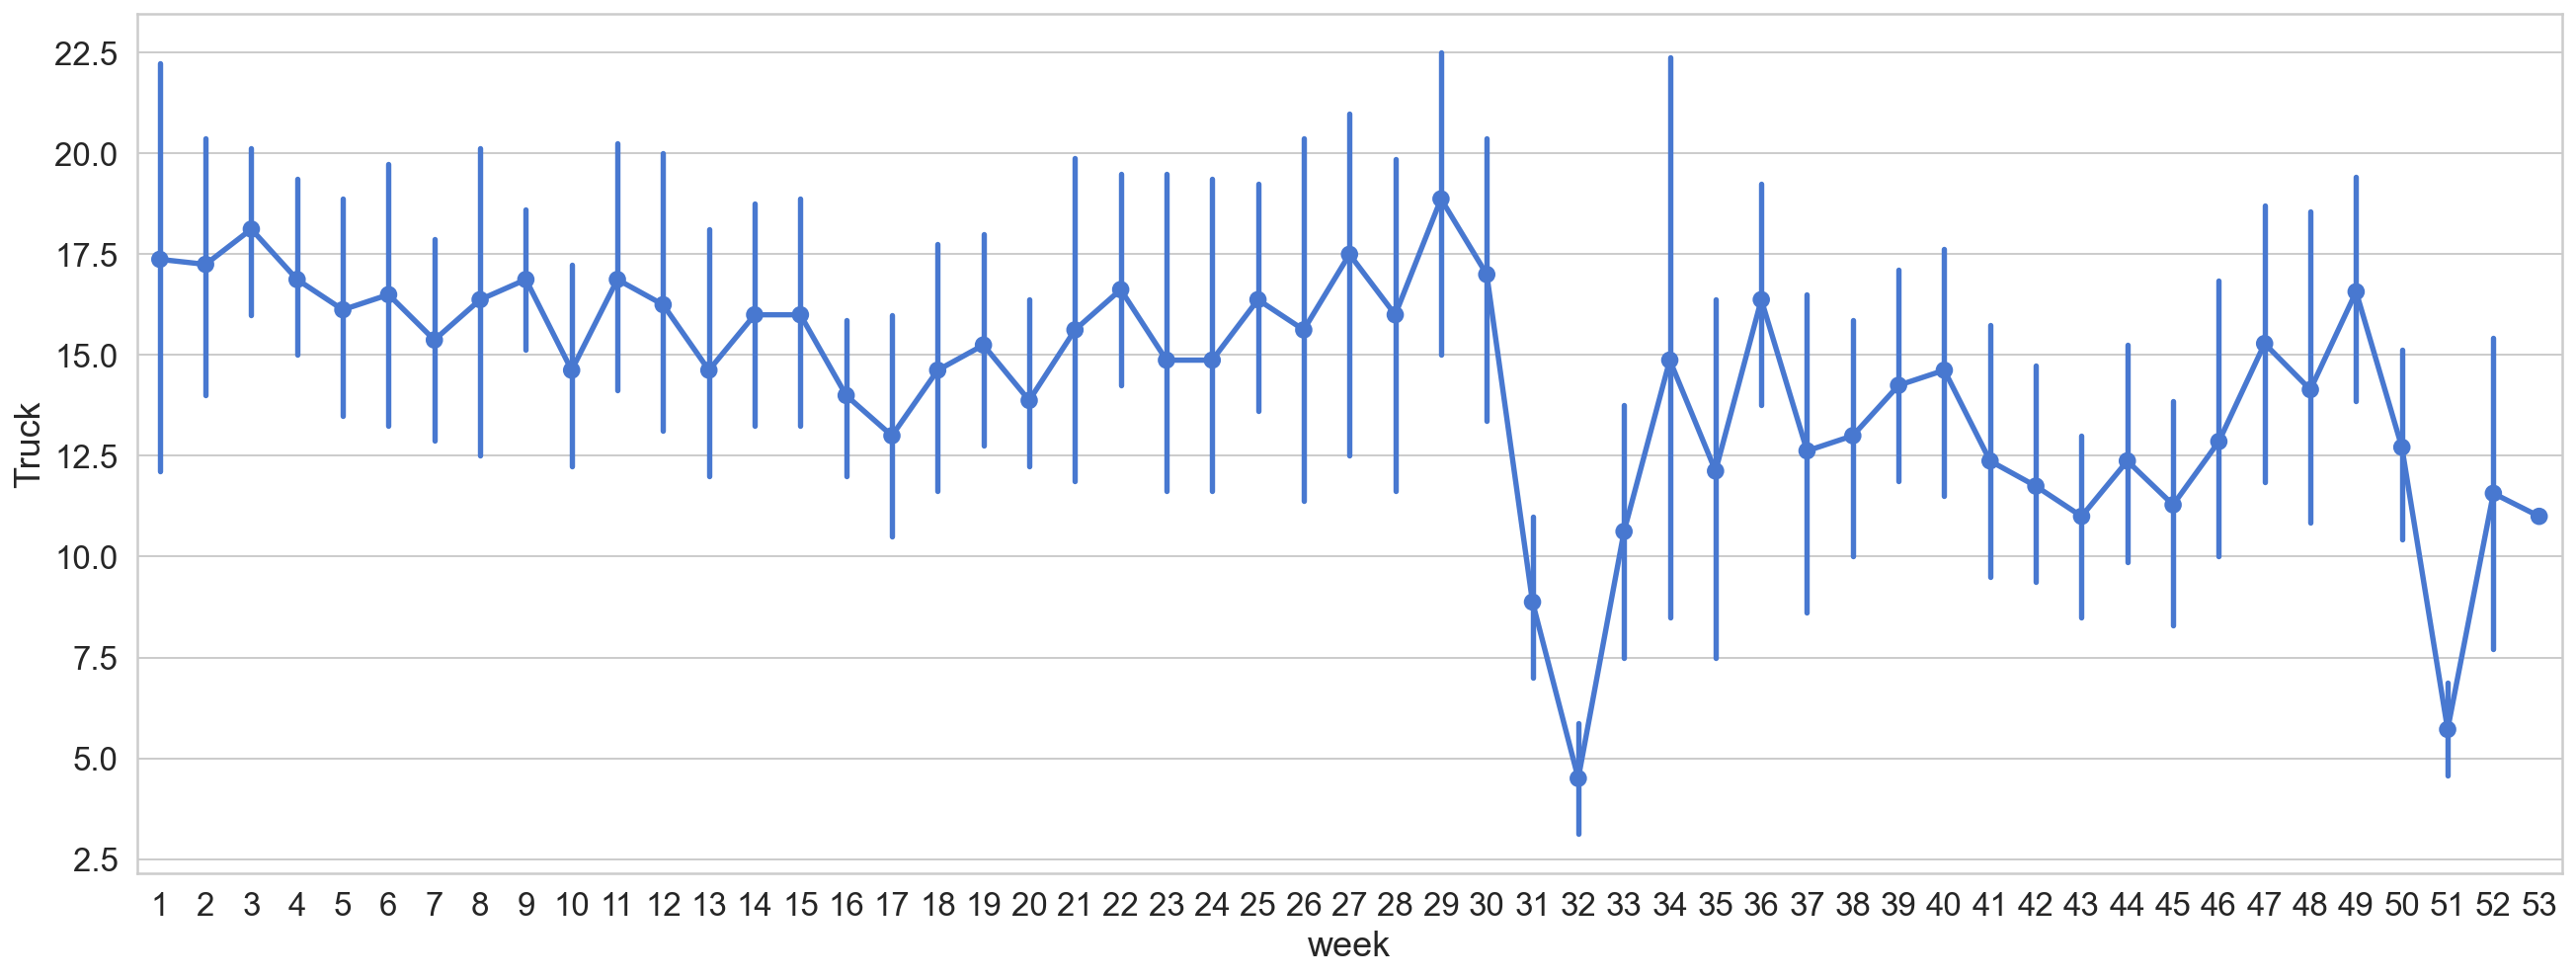

In [8]:
sns.pointplot(data=data,x='week',y='Truck')

In [9]:
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(train.shape,test.shape)

(368, 4) (41, 4)


In [10]:
from sklearn.preprocessing import RobustScaler

In [11]:
scaler = RobustScaler()
scaler.fit(train['Truck'].values.reshape(-1,1))
train['Truck']= scaler.transform(train['Truck'].values.reshape(-1,1))
test['Truck']= scaler.transform(test['Truck'].values.reshape(-1,1))

<ipython-input-11-4e315a9d601b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Truck']= scaler.transform(train['Truck'].values.reshape(-1,1))
<ipython-input-11-4e315a9d601b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Truck']= scaler.transform(test['Truck'].values.reshape(-1,1))


In [12]:
train.head()

,Truck,week,month,quarter
Date,,,,
2011-01-09,1.571429,1,1,1
2011-01-16,0.714286,2,1,1
2011-01-23,1.285714,3,1,1
2011-01-30,1.571429,4,1,1
2011-02-06,-0.285714,5,2,1


In [13]:
def create_dataset(X, y, time_steps=0):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Truck, time_steps)
X_test, y_test = create_dataset(test, test.Truck, time_steps)
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(358, 10, 4) (358,) (31, 10, 4) (31,)


In [16]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
history = model.fit(X_train, y_train,epochs=70,batch_size=20, validation_data=(X_test,y_test),shuffle=False)

Epoch 1/70
18/18 [==============================] - 1s 58ms/step - loss: 0.6063 - val_loss: 0.2852
Epoch 2/70
18/18 [==============================] - 0s 10ms/step - loss: 1.0193 - val_loss: 0.5247
Epoch 3/70
18/18 [==============================] - 0s 11ms/step - loss: 1.0541 - val_loss: 0.2812
Epoch 4/70
18/18 [==============================] - 0s 10ms/step - loss: 0.6212 - val_loss: 0.2548
Epoch 5/70
18/18 [==============================] - 0s 10ms/step - loss: 0.7217 - val_loss: 0.2535
Epoch 6/70
18/18 [==============================] - 0s 11ms/step - loss: 0.6367 - val_loss: 0.2544
Epoch 7/70
18/18 [==============================] - 0s 10ms/step - loss: 0.6404 - val_loss: 0.2705
Epoch 8/70
18/18 [==============================] - 0s 10ms/step - loss: 0.6030 - val_loss: 0.2596
Epoch 9/70
18/18 [==============================] - 0s 10ms/step - loss: 0.5873 - val_loss: 0.2690
Epoch 10/70
18/18 [==============================] - 0s 11ms/step - loss: 0.5396 - val_loss: 0.2962
Epoch 11/

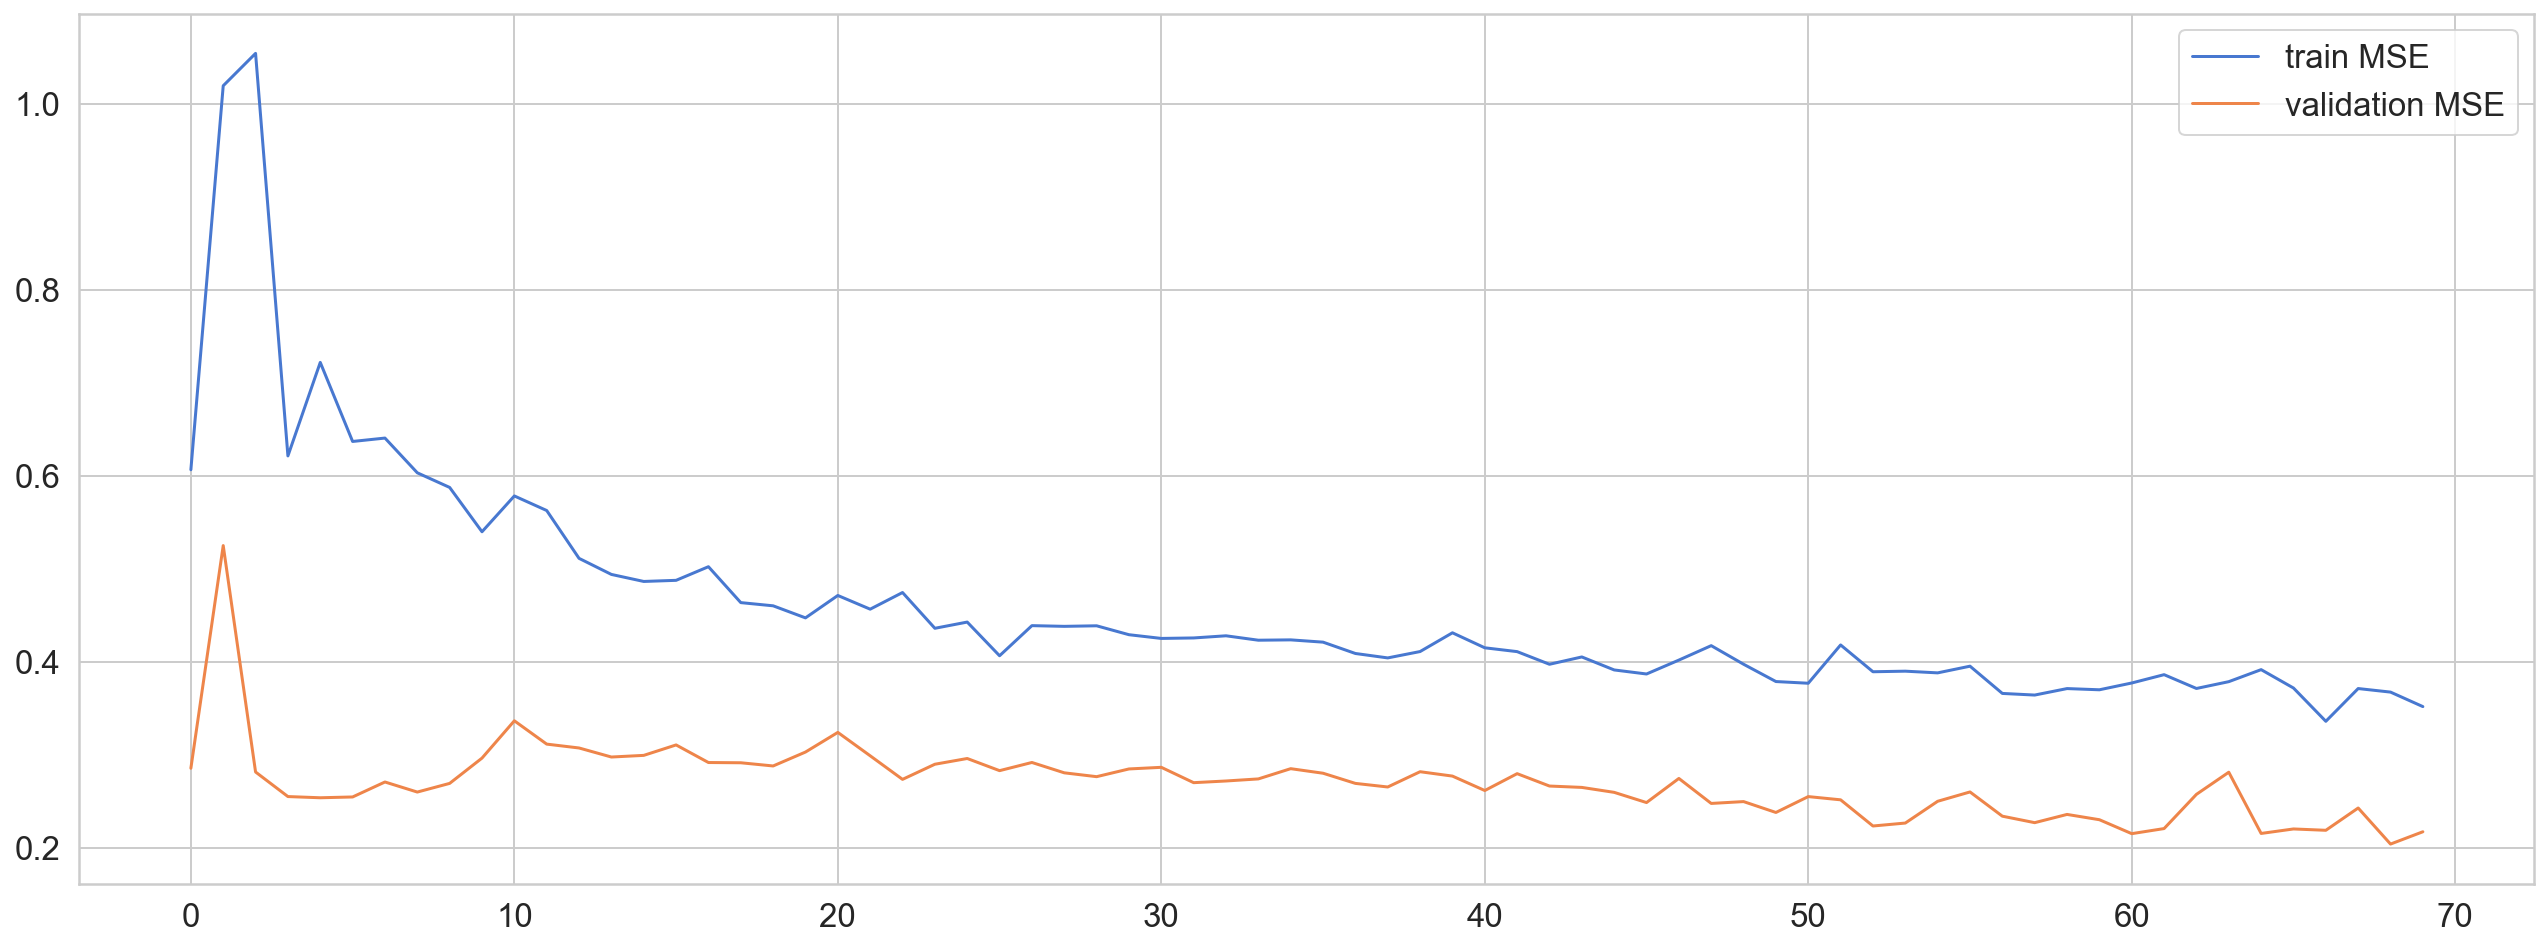

In [18]:
plt.plot(history.history['loss'],label='train MSE')
plt.plot(history.history['val_loss'],label='validation MSE')
plt.legend()

In [19]:
y_pred=model.predict(X_test)

In [20]:
y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [25]:
X_test[30:,:]

array([[[-1.85714286, 34.        ,  8.        ,  3.        ],
        [-0.57142857, 35.        ,  9.        ,  3.        ],
        [ 0.71428571, 36.        ,  9.        ,  3.        ],
        [-0.28571429, 37.        ,  9.        ,  3.        ],
        [-0.42857143, 38.        ,  9.        ,  3.        ],
        [-0.14285714, 39.        ,  9.        ,  3.        ],
        [-0.28571429, 40.        , 10.        ,  4.        ],
        [-0.42857143, 41.        , 10.        ,  4.        ],
        [-0.57142857, 42.        , 10.        ,  4.        ],
        [-0.28571429, 43.        , 10.        ,  4.        ]]])

In [26]:
yhat = model.predict(X_test[30:31,:], verbose=0)
yhat

array([[-0.71913975]], dtype=float32)

In [27]:
yhat_inv=scaler.inverse_transform(yhat)
yhat_inv

array([[8.966022]], dtype=float32)

In [ ]:
mean_absolute_error(y_test_inv.flatten(),y_pred_inv.flatten())

In [ ]:
np.sqrt(mean_squared_error(y_test_inv.flatten(),y_pred_inv.flatten()))

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Week')
plt.legend()
plt.show();

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Truck')
plt.xlabel('Week')
plt.legend()
plt.show();